In [1]:
%pylab inline
from scipy.integrate import odeint 

Populating the interactive namespace from numpy and matplotlib


In [2]:
# define derivative functions 
def deriv(f,t,param): # return derivatives of the array f[r,r',phi]
    # Un vpack parameters
    mu_deriv = param[0]
    ang_mom_deriv = param[1]
    gamma_g_deriv = param[2]
    
    # Function values:
    r = f[0] 
    drdt = f[1] 
    phi = f[2] 
    
    # Derivative definitions:
    drdt = drdt
    dphidt = ang_mom_deriv/(mu_deriv*r**2) 
    d2rdt2 = r*dphidt**2-gamma_g_deriv/(r**2*mu_deriv)   
    return [drdt, d2rdt2, dphidt]

# modify derivative function to record phidot values 
def deriv_wlphi(f,t,param): # return derivatives of the array f[r,r',phi]
    # Un vpack parameters
    mu_deriv = param[0]
    ang_mom_deriv = param[1]
    gamma_g_deriv = param[2]
    
    # Function values:
    r = f[0] 
    drdt = f[1] 
    phi = f[2]
    dphidt = f[3]
    
    # Derivative definitions:
    drdt = drdt
    dphidt = ang_mom_deriv/(mu_deriv*r**2) 
    d2rdt2 = r*dphidt**2-gamma_g_deriv/(r**2*mu_deriv)
    d2phidt2 = (-2)*ang_mom_deriv*drdt/(mu*r**3)
    return [drdt, d2rdt2, dphidt,d2phidt2]

# Find lambda (speed boost coefficient) between orbits transormation 
def findLambda(r1,r2):
    radi1 = r1
    radi3 = r2
    lambda12 = sqrt(2*radi3/(radi1+radi3))
    lambda23 = sqrt((radi1+radi3)/(2*radi1))
    return lambda12,lambda23

In [3]:
# Find analytical Solutions 
def findAna(r1,r2):
    radi1 = r1
    radi3 = r2
    lambda12 = sqrt(2*radi3/(radi1+radi3))
    lambda23 = sqrt((radi1+radi3)/(2*radi1))
    c1 = radi1
    c2 = lambda12**2*c1
    c3 = radi3
    epi1 = 0
    epi2 = lambda12**2-1
    epi3 = 0
    
    phi = linspace(0,2*pi,100)
    r1_ana = array([radi1]*100)
    r2_ana = c2/(1+epi2*cos(phi))
    r3_ana = array([radi3]*100)
    return r1_ana, r2_ana, r3_ana, phi

# plot Hohmann transfer Plot
def plotHohmann(r1_ana, r2_ana, r3_ana, phi,name):
    x1_ana = r1_ana*cos(phi)
    y1_ana = r1_ana*sin(phi)
    x2_ana = r2_ana*cos(phi)
    y2_ana = r2_ana*sin(phi)
    x3_ana = r3_ana*cos(phi)
    y3_ana = r3_ana*sin(phi)   
    figure(figsize(6,6))
    figure()
    plot(x1_ana,y1_ana,'b',label = 'initial orbit')
    plot(x2_ana[:50],y2_ana[:50],'r',label = 'hohmann tranfer')
    plot(x3_ana,y3_ana,'g',label = 'final orbit')
    legend()
    grid()
    title('Analytical Plot for {}'.format(name))

In [4]:
# return the orbits of a given ellipse 
def findOrbit(radi,epi,tFinal):
    time = linspace(0,tFinal,100) #!!!!!!!!!
    r0 = radi
    c = r0*(1+epi)
    phi0 = 0 
    ang_mom = np.sqrt(gamma_g*c*mu) 
    drdt0 = 0
    # Integration of equations of motion for initla orbit
    fInit = [r0,drdt0,phi0] 
    param = [mu,ang_mom, gamma_g] 
    fSoln = odeint(deriv, fInit, time,args=(param,))
    rf = fSoln[:,0]
    drf = fSoln[:,1]
    phif = fSoln[:,2]
    return rf,drf,phif

# for each orbit transfer, plot for r vs time, phi vs time, dr/dt vs time, and orbits 
def plotNumStates(r1,r2,tFinal,name):
    radi1 = r1
    radi2 = r1
    radi3 = r2
    lambda12, lambda23 = findLambda(radi1,radi3)
    epi1 = 0
    epi2 = lambda12**2-1
    epi3 = 0

    rf1,drf1,phif1 = findOrbit(radi1,epi1,tFinal)
    rf2,drf2,phif2 = findOrbit(radi2,epi2,tFinal)
    rf3,drf3,phif3 = findOrbit(radi3,epi3,tFinal)

    time = linspace(0,tFinal,100) 
    figure(figsize(10,10))
    # plot for r versus t
    figure()
    subplot(2,2,1)
    grid()
    plot(time,rf1,'r',label = 'Initial Orbit')
    plot(time,rf2,'g',label = 'Homann Transfer')
    plot(time,rf3,'y',label = 'Final Orbit')
    plt.xlabel('t (s)')
    plt.ylabel('r (m)')
    legend()
    plt.title('r versus t for {}'.format(name)) 
    # plot for dr/dt versus t
    subplot(2,2,2)
    grid()
    plot(time,drf1,'r',label = 'Initial Orbit')
    plot(time,drf2,'g',label = 'Homann Transfer')
    plot(time,drf3,'y',label = 'Final Orbit')
    legend()
    plt.xlabel('t (s)')
    plt.ylabel('dr/dt (m/s)')
    plt.title('dr/dt versus t for {}'.format(name)) 
    # plot for phi versus t
    subplot(2,2,3)
    grid()
    plot(time,phif1,'r',label = 'Initial Orbit')
    plot(time,phif2,'g',label = 'Homann Transfer')
    plot(time,phif3,'y',label = 'Final Orbit')
    legend()
    plt.xlabel('t')
    plt.ylabel('phi')
    plt.title('phi versus t for{}'.format(name)) 
    # plot in polar 
    figure(figsize(5,5))
    figure()
    polar(phif1,rf1,'r',label = 'Inital Orbit')
    polar(phif2,rf2,'g', label = 'Homann Transfer')
    polar(phif3,rf3,'y', label = 'Final Orbit')
    legend()
    title('polar coord for {}'.format(name)) 

In [5]:
# functions for error analysis 
# this function compares the mean error for the difference in r_ana and r_num
def returnError_radi(r1,r2,tFinal,name):
    result = {}
    # Numerical Solutions
    radi1 = r1
    radi2 = r1
    radi3 = r2
    lambda12, lambda23 = findLambda(radi1,radi3)
    epi1 = 0
    epi2 = lambda12**2-1
    epi3 = 0
    r1_num,drf,phi1_num = findOrbit(radi1,epi1,tFinal)
    r2_num,drf,phi2_num = findOrbit(radi2,epi2,tFinal)
    r3_num,drf,phi3_num = findOrbit(radi3,epi3,tFinal)
    # Initla Orbit
    r1_ana = radi1/(1+epi1*cos(phi1_num))
    result['Initla Orbit'] = np.mean(r1_num-r1_ana)
    # Hohmann Transfer
    r2_ana = (lambda12**2*radi1)/(1+epi2*cos(phi2_num))
    result['Hohmann Transfer'] = np.mean(r2_num-r2_ana)/np.mean(r2_ana)
    # Final Orbit
    r3_ana = radi3/(1+epi3*cos(phi3_num))
    result['Final Orbit'] = np.mean(r3_num-r3_ana)
    return result

# print out mean error in r
def printError_radi(r1,r2,tFinal,name):
    print(name)
    error_dict = returnError_radi(r1,r2,tFinal,name)
    for i, (k, v) in enumerate(error_dict.items()):
        print('Mean Radial Error for the', k, ':', v)

# this revised version of derivative function will also retulr phidot 
def deriv_wlphi(f,t,param): # return derivatives of the array f[r,r',phi]
    # Un vpack parameters
    mu_deriv = param[0]
    ang_mom_deriv = param[1]
    gamma_g_deriv = param[2]
    
    # Function values:
    r = f[0] 
    drdt = f[1] 
    phi = f[2]
    dphidt = f[3]
    
    # Derivative definitions:
    drdt = drdt
    dphidt = ang_mom_deriv/(mu_deriv*r**2) 
    d2rdt2 = r*dphidt**2-gamma_g_deriv/(r**2*mu_deriv)
    d2phidt2 = (-2)*ang_mom_deriv*drdt/(mu*r**3)
    return [drdt, d2rdt2, dphidt,d2phidt2]

# This function will check the conservation of angular momentum 
def returnError_angmom(r1,r2,tFina,name):
    result = {}
    radi1 = r1
    radi2 = r1
    radi3 = r2
    angmom1_ana = np.sqrt(gamma_g*radi1*mu)
    phidot1 = angmom1_ana/(mu*radi1**2)
    time = linspace(0,tFinal,100) 
    fSoln1 = odeint(deriv_wlphi, [radi1,0,0, phidot1], time,
                    args=([mu,angmom1_ana, gamma_g] ,))
    # angmom for orbit 2
    angmom1_num = fSoln1[:,3]*mu*fSoln1[:,0]**2
    # angmom for orbit 2
    angmom2_ana = np.sqrt(gamma_g*radi1*mu)
    phidot2 = angmom2_ana/(mu*radi1**2)
    time = linspace(0,3200,100) 
    fSoln2 = odeint(deriv_wlphi, [radi1,0,0,phidot2] , time,
                    args=([mu,angmom2_ana, gamma_g],))
    angmom2_num = fSoln2[:,3]*mu*fSoln2[:,0]**2
    # angmom for orbit 3
    angmom3_ana = np.sqrt(gamma_g*radi3*mu)
    phidot3 = angmom3_ana/(mu*radi3**2)
    time = linspace(0,7000,100) 
    fSoln3 = odeint(deriv_wlphi, [radi3,0,0,phidot3] , time,
                    args=([mu,angmom3_ana, gamma_g] ,))
    angmom3_num = fSoln3[:,3]*mu*fSoln3[:,0]**2
    # calculate the error in Angular momentum
    result['Initla Orbit'] = np.mean((angmom1_num - angmom1_ana) / angmom1_ana)
    result['Homann Transfer'] = np.mean((angmom2_num - angmom2_ana) / angmom2_ana)
    result['Final Orbit'] = error3 = np.mean((angmom3_num - angmom3_ana) / angmom3_ana)
    return result

def printError_angmom(r1,r2,tFina):
    print(name)
    error_dict = returnError_angmom(r1,r2,tFinal,name)
    for i, (k, v) in enumerate(error_dict.items()):
        print('Mean error in angular momentum for the ', k, ':', v)

In [6]:
# Inorder to maintain 298 Kelvin surface temperature. 
# The radius of earth sum distance are listed bellow. 
# We will perform Homann Transfer for each of the two subsequent orbits 
r_current = 1.5e11
r_hCore = 1.94e11
r_redGiant = 6.328e12
r_HoriBranch = 8.36e11
r_HeCore = 7.15e12

# Constants 
m1 = 2e30
m2 = 6e24
G = 6.67e-11
gamma_g = G*m2*m1
mu = (m1*m2)/(m1+m2)

In [7]:
"""
For each ease of orbital transition, we need to perform the following steps:
1. Find analytical solutions
2. Plot analytical orbits
3. Find nuerical solutions 
4. Plot numerical plots 
5. Analyze accuracy by comparing numerical values to analytical values 
6. Analyze accuracy by checking the conservation of momentum 
"""

'\nFor each ease of orbital transition, we need to perform the following steps:\n1. Find analytical solutions\n2. Plot analytical orbits\n3. Find nuerical solutions \n4. Plot numerical plots \n5. Analyze accuracy by comparing numerical values to analytical values \n6. Analyze accuracy by checking the conservation of momentum \n'

<Figure size 432x432 with 0 Axes>

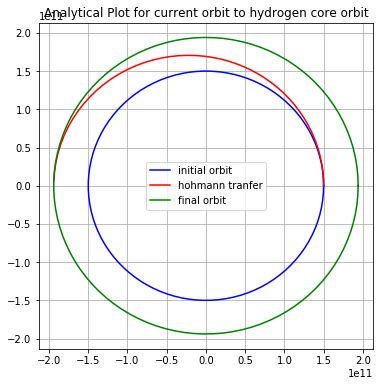

In [8]:
error_radi = []
error_angmom = []
lambdaSet = []
# Case 1: r_current -> r_hCore
# 1.1 Find analytical solutions 
name = 'current orbit to hydrogen core orbit'
rInit = r_current
rFin = r_hCore
r1_ana1, r2_ana1, r3_ana1, phi1 = findAna(rInit,rFin)
# 1.2 plot analytical plots 
plotHohmann(r1_ana1, r2_ana1, r3_ana1, phi1,name)

<Figure size 720x720 with 0 Axes>

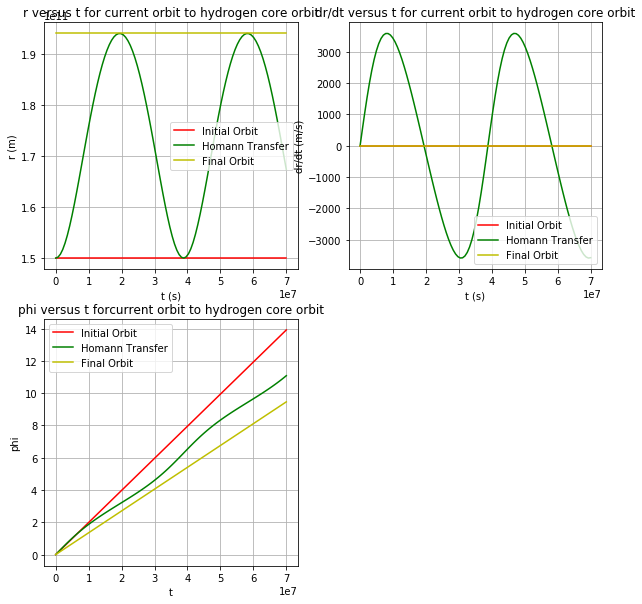

<Figure size 360x360 with 0 Axes>

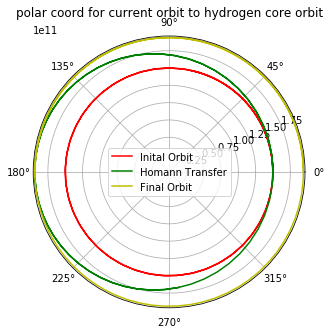

In [9]:
# 1.3 find numerical solutions 
radi1 = rInit
radi2 = rInit
radi3 = rFin
lambda12, lambda23 = findLambda(radi1,radi3)
epi1 = 0
epi2 = lambda12**2-1
epi3 = 0
tFinal = 70000000
lambdaSet.append(lambda12)
lambdaSet.append(lambda23)
r1_num1,drf1,phi1_num1 = findOrbit(radi1,epi1,tFinal)
r2_num1,drf2,phi2_num1 = findOrbit(radi2,epi2,tFinal)
r3_num1,drf3,phi3_num1 = findOrbit(radi3,epi3,tFinal)
# 1.4 Plot numerical plots 
plotNumStates(rInit,rFin,tFinal,name)

In [10]:
# 1.5 Error Analysis, comparing numerical results by analytical results
error_radi.append(list(returnError_radi(rInit,rFin,tFinal,name).values()))
error_angmom.append(list(returnError_angmom(rInit,rFin,tFinal,name).values()))
printError_radi(rInit,rFin,tFinal,name)
printError_angmom(rInit,rFin,tFinal)

current orbit to hydrogen core orbit
Mean Radial Error for the Initla Orbit : -8.819580078125e-05
Mean Radial Error for the Hohmann Transfer : -2.919997041695221e-09
Mean Radial Error for the Final Orbit : 1.52587890625e-05
current orbit to hydrogen core orbit
Mean error in angular momentum for the  Initla Orbit : 5.801514377731344e-16
Mean error in angular momentum for the  Homann Transfer : 0.0
Mean error in angular momentum for the  Final Orbit : 0.0


<Figure size 432x432 with 0 Axes>

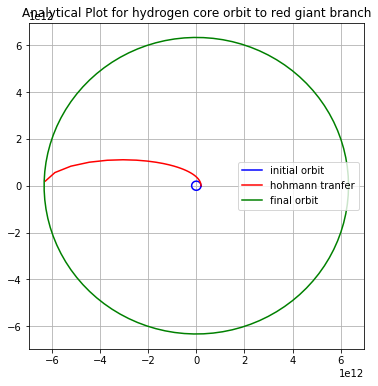

In [11]:
# Case 2: r_hCore -> r_redGiant
# 2.1 Find analytical solutions 
name = 'hydrogen core orbit to red giant branch'
rInit = r_hCore
rFin = r_redGiant
r1_ana1, r2_ana1, r3_ana1, phi1 = findAna(rInit,rFin)
# 2.2 plot analytical plots 
plotHohmann(r1_ana1, r2_ana1, r3_ana1, phi1,name)

<Figure size 720x720 with 0 Axes>

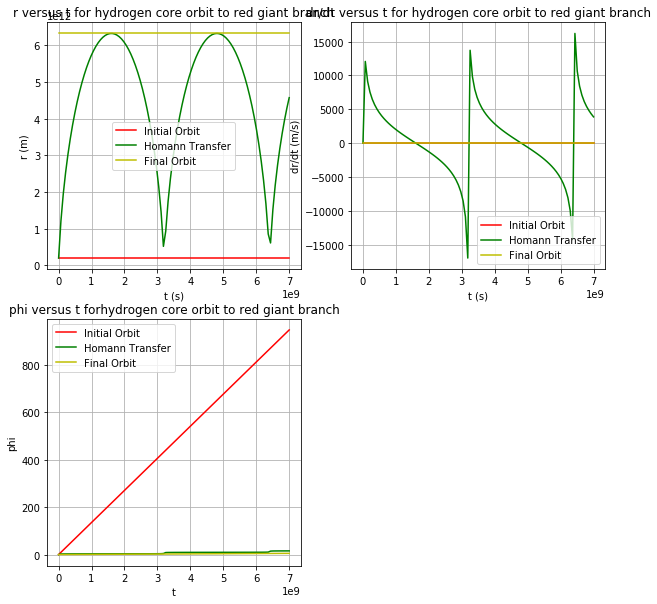

<Figure size 360x360 with 0 Axes>

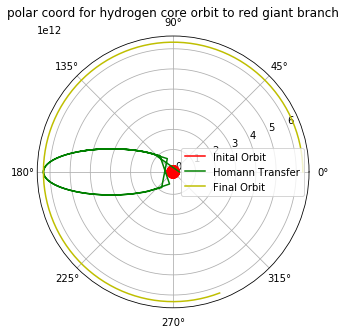

In [12]:
# 2.3 find numerical solutions 
radi1 = rInit
radi2 = rInit
radi3 = rFin
lambda12, lambda23 = findLambda(radi1,radi3)
epi1 = 0
epi2 = lambda12**2-1
epi3 = 0
tFinal = 7000000000
lambdaSet.append(lambda12)
lambdaSet.append(lambda23)
r1_num1,drf1,phi1_num1 = findOrbit(radi1,epi1,tFinal)
r2_num1,drf2,phi2_num1 = findOrbit(radi2,epi2,tFinal)
r3_num1,drf3,phi3_num1 = findOrbit(radi3,epi3,tFinal)
# 1.4 Plot numerical plots 
plotNumStates(rInit,rFin,tFinal,name)

In [13]:
# 2.5 Error Analysis, comparing numerical results by analytical results
error_radi.append(list(returnError_radi(rInit,rFin,tFinal,name).values()))
error_angmom.append(list(returnError_angmom(rInit,rFin,tFinal,name).values()))
printError_radi(rInit,rFin,tFinal,name)
printError_angmom(rInit,rFin,tFinal)

hydrogen core orbit to red giant branch
Mean Radial Error for the Initla Orbit : -3.326416015625e-05
Mean Radial Error for the Hohmann Transfer : -6.792331099324245e-07
Mean Radial Error for the Final Orbit : -0.007841796875
hydrogen core orbit to red giant branch
Mean error in angular momentum for the  Initla Orbit : -2.01202784481158e-16
Mean error in angular momentum for the  Homann Transfer : 0.0
Mean error in angular momentum for the  Final Orbit : 0.0


<Figure size 432x432 with 0 Axes>

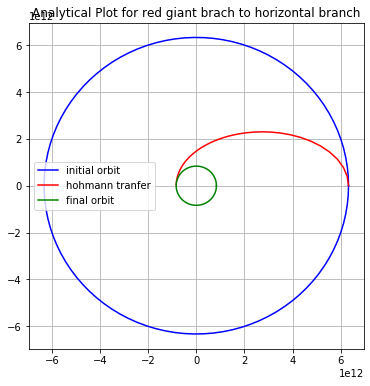

In [14]:
# Case 1: r_redGiant -> r_HoriBranch
# 3.1 Find analytical solutions 
name = 'red giant brach to horizontal branch'
rInit = r_redGiant
rFin = r_HoriBranch
r1_ana1, r2_ana1, r3_ana1, phi1 = findAna(rInit,rFin)
# 3.2 plot analytical plots 
plotHohmann(r1_ana1, r2_ana1, r3_ana1, phi1,name)

<Figure size 720x720 with 0 Axes>

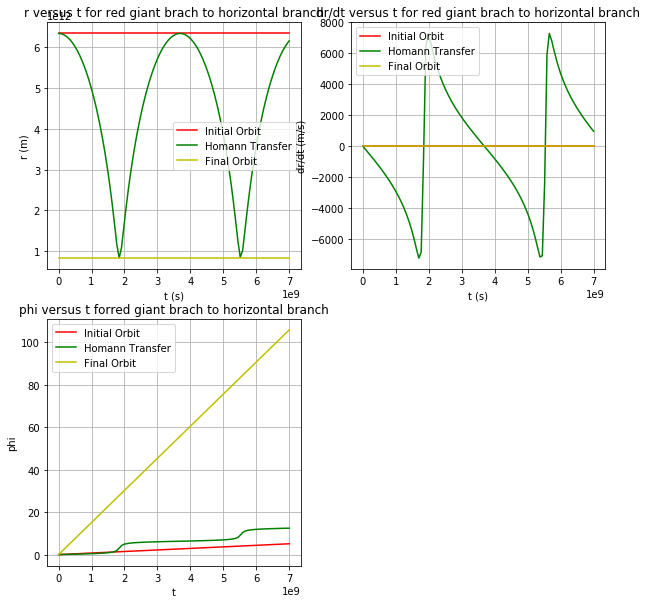

<Figure size 360x360 with 0 Axes>

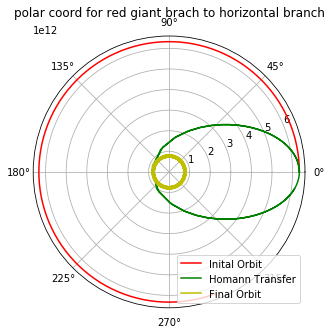

In [15]:
# 3.3 find numerical solutions 
radi1 = rInit
radi2 = rInit
radi3 = rFin
lambda12, lambda23 = findLambda(radi1,radi3)
epi1 = 0
epi2 = lambda12**2-1
epi3 = 0
tFinal = 7000000000
lambdaSet.append(lambda12)
lambdaSet.append(lambda23)
r1_num1,drf1,phi1_num1 = findOrbit(radi1,epi1,tFinal)
r2_num1,drf2,phi2_num1 = findOrbit(radi2,epi2,tFinal)
r3_num1,drf3,phi3_num1 = findOrbit(radi3,epi3,tFinal)
# 3.4 Plot numerical plots 
plotNumStates(rInit,rFin,tFinal,name)

In [16]:
# 3.5 Error Analysis, comparing numerical results by analytical results
error_radi.append(list(returnError_radi(rInit,rFin,tFinal,name).values()))
error_angmom.append(list(returnError_angmom(rInit,rFin,tFinal,name).values()))
printError_radi(rInit,rFin,tFinal,name)
printError_angmom(rInit,rFin,tFinal)

red giant brach to horizontal branch
Mean Radial Error for the Initla Orbit : -0.007841796875
Mean Radial Error for the Hohmann Transfer : -4.881572671631801e-07
Mean Radial Error for the Final Orbit : 0.00031982421875
red giant brach to horizontal branch
Mean error in angular momentum for the  Initla Orbit : -2.884903129200189e-17
Mean error in angular momentum for the  Homann Transfer : 0.0
Mean error in angular momentum for the  Final Orbit : 1.5263635543963572e-16


<Figure size 432x432 with 0 Axes>

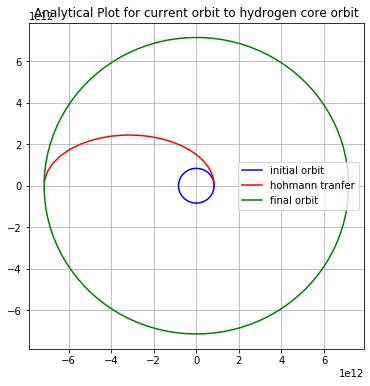

In [17]:
# Case 1: r_HoriBranch -> r_HeCore
# 4.1 Find analytical solutions 
name = 'current orbit to hydrogen core orbit'
rInit = r_HoriBranch
rFin = r_HeCore
r1_ana1, r2_ana1, r3_ana1, phi1 = findAna(rInit,rFin)
# 4.2 plot analytical plots 
plotHohmann(r1_ana1, r2_ana1, r3_ana1, phi1,name)

<Figure size 720x720 with 0 Axes>

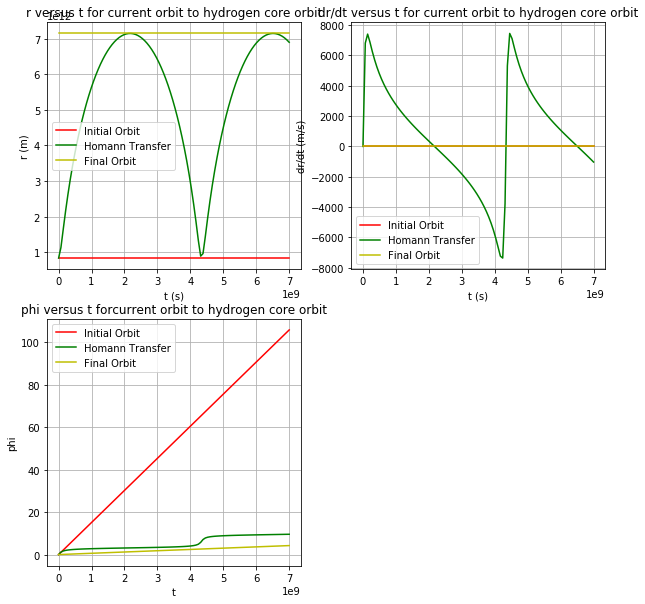

<Figure size 360x360 with 0 Axes>

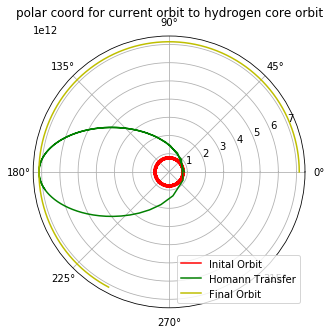

In [18]:
# 4.3 find numerical solutions 
radi1 = rInit
radi2 = rInit
radi3 = rFin
lambda12, lambda23 = findLambda(radi1,radi3)
epi1 = 0
epi2 = lambda12**2-1
epi3 = 0
tFinal = 7000000000
lambdaSet.append(lambda12)
lambdaSet.append(lambda23)
r1_num1,drf1,phi1_num1 = findOrbit(radi1,epi1,tFinal)
r2_num1,drf2,phi2_num1 = findOrbit(radi2,epi2,tFinal)
r3_num1,drf3,phi3_num1 = findOrbit(radi3,epi3,tFinal)
# 4.4 Plot numerical plots 
plotNumStates(rInit,rFin,tFinal,name)

In [19]:
# 4.5 Error Analysis, comparing numerical results by analytical results
error_radi.append(list(returnError_radi(rInit,rFin,tFinal,name).values()))
error_angmom.append(list(returnError_angmom(rInit,rFin,tFinal,name).values()))
printError_radi(rInit,rFin,tFinal,name)
printError_angmom(rInit,rFin,tFinal)

current orbit to hydrogen core orbit
Mean Radial Error for the Initla Orbit : 0.00031982421875
Mean Radial Error for the Hohmann Transfer : -1.343372421248169e-07
Mean Radial Error for the Final Orbit : 0.029609375
current orbit to hydrogen core orbit
Mean error in angular momentum for the  Initla Orbit : -9.081863148658325e-16
Mean error in angular momentum for the  Homann Transfer : 1.5263635543963572e-16
Mean error in angular momentum for the  Final Orbit : 0.0


In [23]:
# we Now summarize the table of lambdas (the speed boost factor)
from pandas import Series, DataFrame
import pandas as pd
index = [('r_current -> r_hCore', 'Initial Orbit->Homann Transfer'),('r_current -> r_hCore', 'Homann Transfer->Final Orbit'),
        ('r_hCore -> r_redGiant', 'Initial Orbit->Homann Transfer'),('r_hCore -> r_redGiant', 'Homann Transfer->Final Orbit'),
        ('r_redGiant -> r_HoriBranch', 'Initial Orbit->Homann Transfer'),('r_redGiant -> r_HoriBranch', 'Homann Transfer->Final Orbit'),
        ('r_HoriBranch -> r_HeCore', 'Initial Orbit->Homann Transfer'),('r_HoriBranch -> r_HeCore', 'Homann Transfer->Final Orbit')]
index = pd.MultiIndex.from_tuples(index)
lambda_ser = pd.Series(lambdaSet,index=index)
df_lambda = DataFrame({'lambda':lambda_ser})
df_lambda

lambda
r_current -> r_hCore       Initial Orbit->Homann Transfer  1.062030
                           Homann Transfer->Final Orbit    1.070825
r_hCore -> r_redGiant      Initial Orbit->Homann Transfer  1.393022
                           Homann Transfer->Final Orbit    4.099912
r_redGiant -> r_HoriBranch Initial Orbit->Homann Transfer  0.483104
                           Homann Transfer->Final Orbit    0.752367
r_HoriBranch -> r_HeCore   Initial Orbit->Homann Transfer  1.338146
                           Homann Transfer->Final Orbit    2.185478

In [24]:
# we Now summarize the table of errors 
error_radi = array(error_radi).flatten()
error_angmom = array(error_angmom).flatten()
index = [('r_current -> r_hCore', 'Initial Orbit'),('r_current -> r_hCore', 'Homann Transfer'),('r_current -> r_hCore', 'Final Orbit'),
        ('r_hCore -> r_redGiant', 'Initial Orbit'),('r_hCore -> r_redGiant', 'Homann Transfer'),('r_hCore -> r_redGiant', 'Final Orbit'),
        ('r_redGiant -> r_HoriBranch', 'Initial Orbit'),('r_redGiant -> r_HoriBranch', 'Homann Transfer'),('r_redGiant -> r_HoriBranch', 'Final Orbit'),
        ('r_HoriBranch -> r_HeCore', 'Initial Orbit'),('r_HoriBranch -> r_HeCore', 'Homann Transfer'),('r_HoriBranch -> r_HeCore', 'Final Orbit'),]
index = pd.MultiIndex.from_tuples(index)
radi_ser = pd.Series(error_radi,index=index)
angmom_ser = pd.Series(error_angmom,index=index)
df_error = DataFrame({'Error in r':radi_ser, 'Error in Angular Momentum': angmom_ser})
df_error

Error in r  \
r_current -> r_hCore       Initial Orbit   -8.819580e-05   
                           Homann Transfer -2.919997e-09   
                           Final Orbit      1.525879e-05   
r_hCore -> r_redGiant      Initial Orbit   -3.326416e-05   
                           Homann Transfer -6.792331e-07   
                           Final Orbit     -7.841797e-03   
r_redGiant -> r_HoriBranch Initial Orbit   -7.841797e-03   
                           Homann Transfer -4.881573e-07   
                           Final Orbit      3.198242e-04   
r_HoriBranch -> r_HeCore   Initial Orbit    3.198242e-04   
                           Homann Transfer -1.343372e-07   
                           Final Orbit      2.960938e-02   

                                            Error in Angular Momentum  
r_current -> r_hCore       Initial Orbit                 5.801514e-16  
                           Homann Transfer               0.000000e+00  
                           Final Orbit                   0.000000e+00  
r_hCore -> r_redGiant      Initial Orbit                -2.012028e-16  
                           Homann Transfer               0.000000e+00  
                           Final Orbit                   0.000000e+00  
r_redGiant -> r_HoriBranch Initial Orbit                -2.884903e-17  
                           Homann Transfer               0.000000e+00  
                           Final Orbit                   1.526364e-16  
r_HoriBranch -> r_HeCore   Initial Orbit                -9.081863e-16  
                           Homann Transfer               1.526364e-16  
                           Final Orbit                   0.000000e+00